In [1]:
#necessary imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
import sklearn.metrics as metrics
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

In [2]:
df= pd.read_excel('YekdemBirimMaliyeti.xls')

In [3]:
df.tail()

Donem    Versiyon  Birim_Maliyeti(TL)
561  Kas - 2021  Kas - 2021              52.642
562  Kas - 2021  Ara - 2021              52.775
563  Kas - 2021  Oca - 2022              52.758
564  Ara - 2021  Ara - 2021              71.225
565  Ara - 2021  Oca - 2022              71.258

In [4]:
df = df.drop("Versiyon",axis=1)
df.describe()

Birim_Maliyeti(TL)
count          566.000000
mean            73.705827
std             55.108792
min             -0.936000
25%             32.882750
50%             66.963000
75%            106.631500
max            233.319000

In [5]:
df["month"] = df["Donem"].str.split(' - ', expand=True)[0]
df["year"] = df["Donem"].str.split(' - ', expand=True)[1]
df.head(5)

Donem  Birim_Maliyeti(TL) month  year
0  Ara - 2011               0.168   Ara  2011
1  Ara - 2011               0.168   Ara  2011
2  Oca - 2012              -0.003   Oca  2012
3  Oca - 2012              -0.006   Oca  2012
4  Şub - 2012              -0.936   Şub  2012

In [6]:
months = df["month"].squeeze()

In [7]:
months = months.map({'Oca':1, 'Şub':2, 'Mar':3, 'Nis':4, 'May':5,'Haz':6,'Tem':7,'Ağu':8,'Eyl':9,'Eki':10,'Kas':11,'Ara':12})
months

0      12
1      12
2       1
3       1
4       2
       ..
561    11
562    11
563    11
564    12
565    12
Name: month, Length: 566, dtype: int64

In [8]:
df['month'] = months.to_frame()
df["Donem"] = pd.to_datetime(df['year'].astype(str) + ' ' + df['month'].astype(str))
df["Donem"] = df['Donem'].dt.strftime('%Y-%m')
df = df.drop(["month","year"],axis=1)
df_group = df.groupby("Donem").mean()
df_group.index = pd.to_datetime(df_group.index)
df_group.index

DatetimeIndex(['2011-12-01', '2012-01-01', '2012-02-01', '2012-03-01',
               '2012-04-01', '2012-05-01', '2012-06-01', '2012-07-01',
               '2012-08-01', '2012-09-01',
               ...
               '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01',
               '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01',
               '2021-11-01', '2021-12-01'],
              dtype='datetime64[ns]', name='Donem', length=121, freq=None)

In [9]:
df_group.head()

Birim_Maliyeti(TL)
Donem                         
2011-12-01              0.1680
2012-01-01             -0.0045
2012-02-01             -0.9355
2012-03-01              0.5110
2012-04-01              1.6110

In [10]:
df_group.describe()

Birim_Maliyeti(TL)
count          121.000000
mean            42.926085
std             49.159154
min             -0.935500
25%              1.375000
50%             26.741500
75%             66.717143
max            233.297545

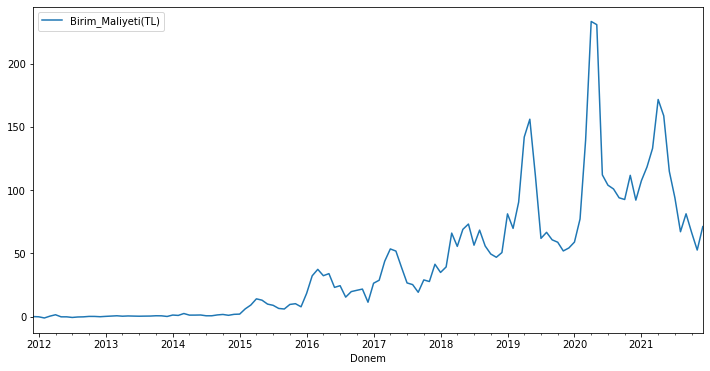

In [11]:
df_group.plot(figsize = (12,6))
plt.show()

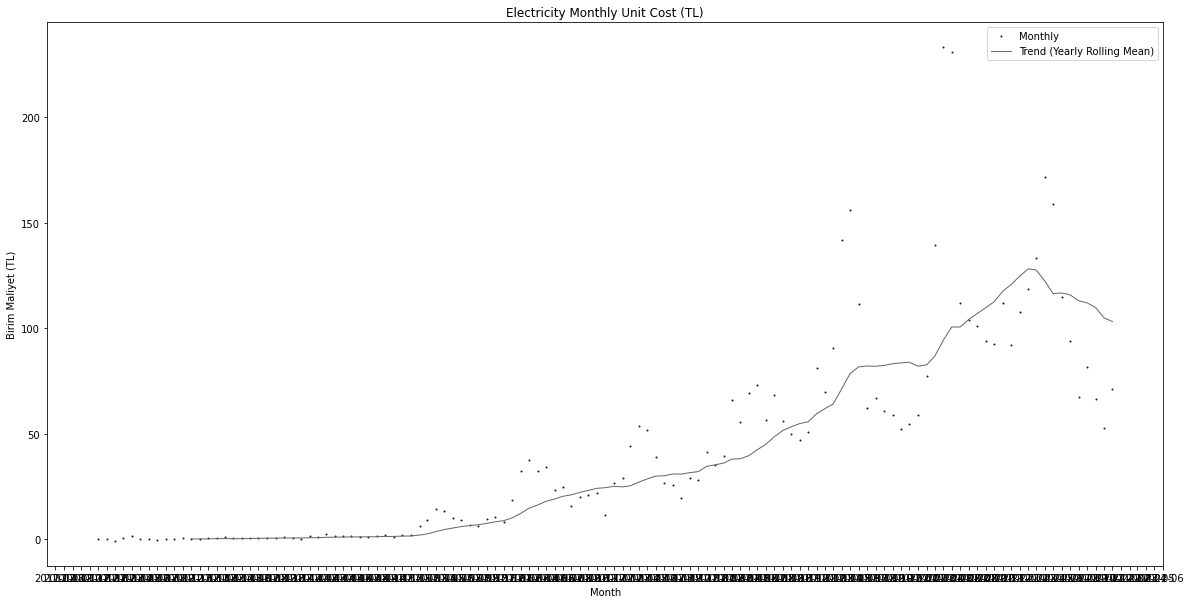

In [12]:
df_monthly_rol = df_group.rolling(12).mean()
fig, ax = plt.subplots(figsize = (20,10))
ax.plot(df_group['Birim_Maliyeti(TL)'], marker='o', markersize=1, color='0.1',linestyle='None', label='Monthly')
ax.plot(df_monthly_rol['Birim_Maliyeti(TL)'], color='0.4', linewidth=1, label='Trend (Yearly Rolling Mean)')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.legend()
ax.set_xlabel('Month')
ax.set_ylabel('Birim Maliyet (TL)')
ax.set_title('Electricity Monthly Unit Cost (TL)')
plt.show()

In [13]:
from statsmodels.tsa.stattools import adfuller
def test_stationary(data):
    rolling_mean = data.rolling(12).mean()
    rolling_std = data.rolling(12).std()
    plt.plot(data, color="blue",label="Original Data")
    plt.plot(rolling_mean, color="red", label="Mean")
    plt.plot(rolling_std, color="black", label = "Standard Deviation")
    plt.legend(loc="best")
    plt.show()
    
    #Dickey Fuller Test
    adft = adfuller(data,autolag="AIC")
    output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']] , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used","critical value (1%)", "critical value (5%)", "critical value (10%)"]})
    print(output_df) #p>0.05 means not stationary

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose
def test_autocorelation_decompose(data):
    autocorrelation_lag1 = data.autocorr(lag=1)
    print("One Month Lag: ", autocorrelation_lag1)
    autocorrelation_lag6 = data.autocorr(lag=6)
    print("Six Month Lag: ", autocorrelation_lag6)
    autocorrelation_lag9 = data.autocorr(lag=9)
    print("Nine Month Lag: ", autocorrelation_lag9)
    autocorrelation_lag12 = data.autocorr(lag=12)
    print("Twelve Month Lag: ", autocorrelation_lag12)

    decompose = seasonal_decompose(data,model='additive', period=12)
    decompose.plot()
    plt.show()

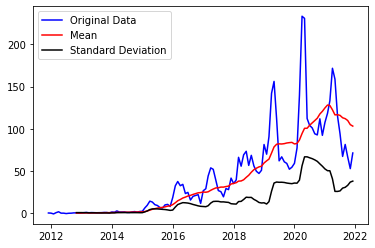

       Values                       Metric
0    0.055633              Test Statistics
1    0.962898                      p-value
2   10.000000             No. of lags used
3  110.000000  Number of observations used
4   -3.491245          critical value (1%)
5   -2.888195          critical value (5%)
6   -2.580988         critical value (10%)


In [15]:
test_stationary(df_group)

One Month Lag:  0.918949832044872
Six Month Lag:  0.6151510143939002
Nine Month Lag:  0.6823523780782758
Twelve Month Lag:  0.8684857404395814


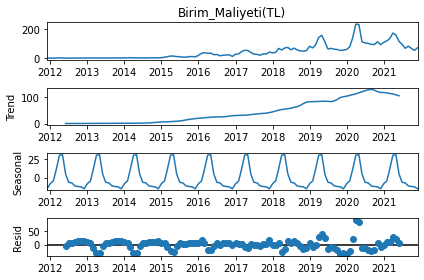

In [16]:
test_autocorelation_decompose(df_group["Birim_Maliyeti(TL)"])

In [17]:
from statsmodels.stats.stattools import durbin_watson
from statsmodels.regression.linear_model import OLS
X =np.arange(len(df_group[["Birim_Maliyeti(TL)"]]))
Y = np.asarray(df_group[["Birim_Maliyeti(TL)"]])
X = sm.add_constant(X)
  
# Fit the ordinary least square method.
ols_res = OLS(Y,X).fit()
# apply durbin watson statistic on the ols residual
durbin_watson(ols_res.resid) # =2 means autocorelation exists

0.47359088920734765

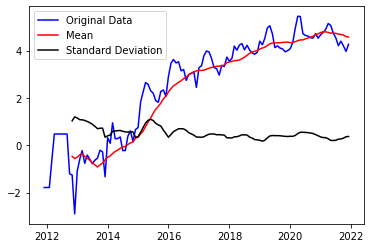

       Values                       Metric
0   -2.563215              Test Statistics
1    0.100841                      p-value
2   12.000000             No. of lags used
3  108.000000  Number of observations used
4   -3.492401          critical value (1%)
5   -2.888697          critical value (5%)
6   -2.581255         critical value (10%)


In [18]:
df_logscale = np.log(df_group)
df_logscale = df_logscale.ffill()
test_stationary(df_logscale)

One Month Lag:  0.9738950614546052
Six Month Lag:  0.8895562624781256
Nine Month Lag:  0.9075141959593815
Twelve Month Lag:  0.9282969723850403


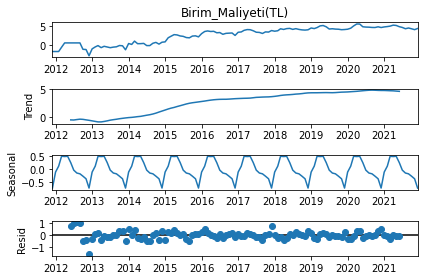

In [19]:
test_autocorelation_decompose(df_logscale["Birim_Maliyeti(TL)"])

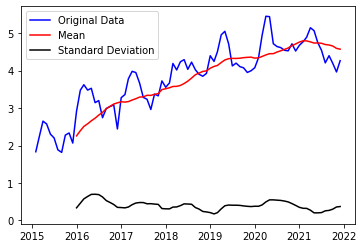

      Values                       Metric
0  -3.658571              Test Statistics
1   0.004735                      p-value
2  10.000000             No. of lags used
3  72.000000  Number of observations used
4  -3.524624          critical value (1%)
5  -2.902607          critical value (5%)
6  -2.588679         critical value (10%)


In [20]:
df_logscale2015 = df_logscale[df_logscale.index > pd.to_datetime("2015-01-01", format='%Y-%m-%d')]
test_stationary(df_logscale2015)

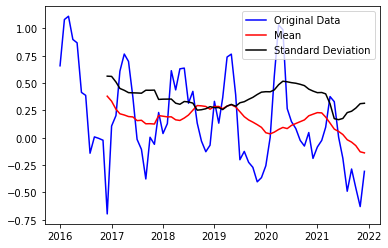

      Values                       Metric
0  -4.807872              Test Statistics
1   0.000053                      p-value
2   2.000000             No. of lags used
3  69.000000  Number of observations used
4  -3.528890          critical value (1%)
5  -2.904440          critical value (5%)
6  -2.589656         critical value (10%)


In [21]:
movingaverage = df_logscale2015.rolling(12).mean()
df_logscale2015minusMA = df_logscale2015 - movingaverage
df_logscale2015minusMA = df_logscale2015minusMA.dropna()
test_stationary(df_logscale2015minusMA)

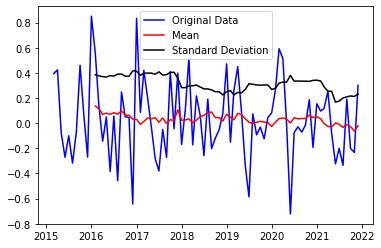

      Values                       Metric
0  -5.598880              Test Statistics
1   0.000001                      p-value
2   9.000000             No. of lags used
3  72.000000  Number of observations used
4  -3.524624          critical value (1%)
5  -2.902607          critical value (5%)
6  -2.588679         critical value (10%)


In [22]:
df_logscale2015diff = df_logscale2015.copy()
df_logscale2015diff["Birim_Maliyeti(TL)"] = df_logscale2015["Birim_Maliyeti(TL)"].diff()
df_logscale2015diff = df_logscale2015diff.dropna()
test_stationary(df_logscale2015diff)

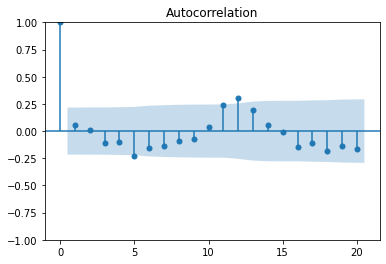

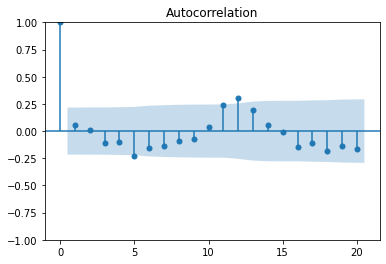

In [23]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(df_logscale2015diff,lags=20)

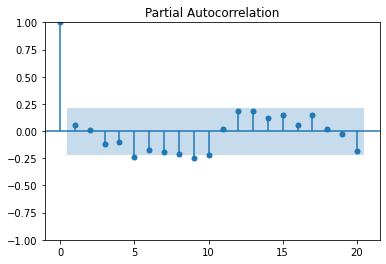

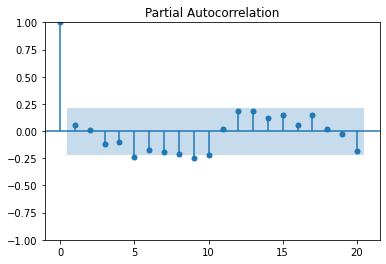

In [24]:
plot_pacf(df_logscale2015diff,lags=20)

# MODEL SETUP

In [25]:
def apply_arima(data):
    import itertools
    p=d=q=range(0,5)
    pdq = list(itertools.product(p,d,q))
    for item in pdq:
        train = data[data.index < pd.to_datetime("2021-07-01", format='%Y-%m-%d')]
        test = data[data.index > pd.to_datetime("2021-06-01", format='%Y-%m-%d')]
        y = train["Birim_Maliyeti(TL)"]
        ARIMAmodel = ARIMA(y, order = (item[0], item[1], item[2]))
        ARIMAmodel = ARIMAmodel.fit()

        y_pred_arima = ARIMAmodel.get_forecast(len(test.index))
        y_pred_arima = y_pred_arima.conf_int(alpha = 0.05) 
        y_pred_arima["Predictions"] = ARIMAmodel.predict(start = y_pred_arima.index[0], end = y_pred_arima.index[-1])
        y_pred_arima.index = test.index
        forecast = y_pred_arima["Predictions"]
        rms = np.sqrt(metrics.mean_squared_error(test,forecast))
        mse = metrics.mean_squared_error(test,forecast)
        r2 = metrics.r2_score(test,forecast)
        mae = metrics.mean_absolute_error(test,forecast)
        print(f"RMSE: {rms} for pdq = {item}", )
        print(f"MSE: {mse} for pdq = {item}")
        print(f"R2: {r2} for pdq = {item}")
        print(f"MAE: {mae} for pdq = {item}")
        plt.plot(train, color = "black",label="Train")
        plt.plot(test, color = "red",label="Test")
        plt.plot(forecast,color='blue',label="Prediction")
        plt.title("Prediction")
        plt.ylabel("Birim_Maliyeti(TL)")
        plt.xlabel('Year-Month')
        sns.set()
        plt.legend()
        plt.show()

RMSE: 0.5294741998603184 for pdq = (0, 0, 0)
MSE: 0.2803429283177244 for pdq = (0, 0, 0)
R2: -7.711623875038011 for pdq = (0, 0, 0)
MAE: 0.4981592101337397 for pdq = (0, 0, 0)


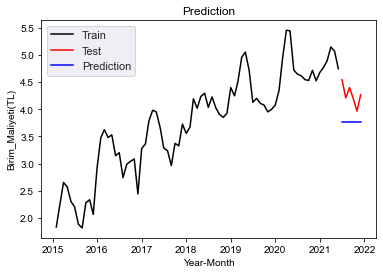

RMSE: 0.46671341559975926 for pdq = (0, 0, 1)
MSE: 0.21782141230079363 for pdq = (0, 0, 1)
R2: -5.768775040201788 for pdq = (0, 0, 1)
MAE: 0.4487010689904966 for pdq = (0, 0, 1)


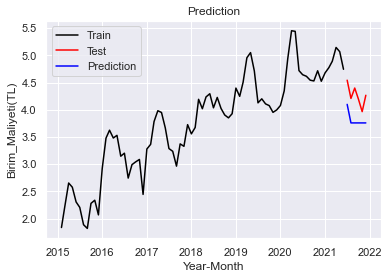

RMSE: 0.4341108860507536 for pdq = (0, 0, 2)
MSE: 0.18845226138777038 for pdq = (0, 0, 2)
R2: -4.856132093155453 for pdq = (0, 0, 2)
MAE: 0.40885313922907135 for pdq = (0, 0, 2)


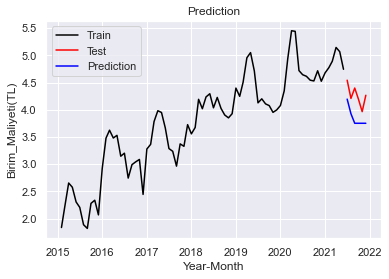

RMSE: 0.428382992616537 for pdq = (0, 0, 3)
MSE: 0.18351198836309998 for pdq = (0, 0, 3)
R2: -4.702613683794513 for pdq = (0, 0, 3)
MAE: 0.3999688010181998 for pdq = (0, 0, 3)


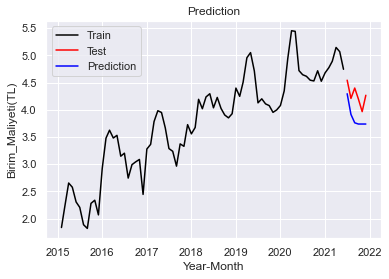

RMSE: 0.3966836534964625 for pdq = (0, 0, 4)
MSE: 0.15735792095130155 for pdq = (0, 0, 4)
R2: -3.889879082421758 for pdq = (0, 0, 4)
MAE: 0.3479599271148602 for pdq = (0, 0, 4)


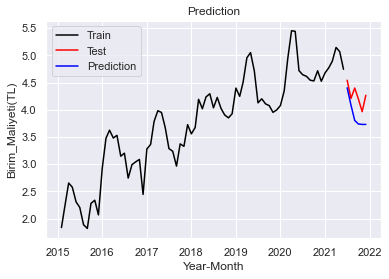

RMSE: 0.5131358381428398 for pdq = (0, 1, 0)
MSE: 0.2633083883865547 for pdq = (0, 1, 0)
R2: -7.1822775289212295 for pdq = (0, 1, 0)
MAE: 0.4807577963069363 for pdq = (0, 1, 0)


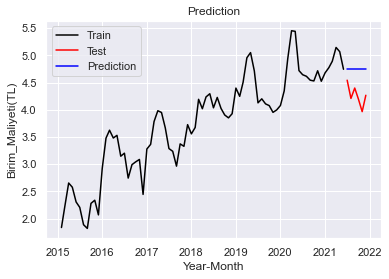

RMSE: 0.4935533480402237 for pdq = (0, 1, 1)
MSE: 0.24359490736171419 for pdq = (0, 1, 1)
R2: -6.569683400056765 for pdq = (0, 1, 1)
MAE: 0.459798409833115 for pdq = (0, 1, 1)


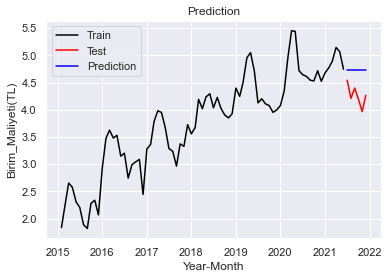

RMSE: 0.4765462610976703 for pdq = (0, 1, 2)
MSE: 0.22709633896616896 for pdq = (0, 1, 2)
R2: -6.056992307040553 for pdq = (0, 1, 2)
MAE: 0.4427003721029134 for pdq = (0, 1, 2)


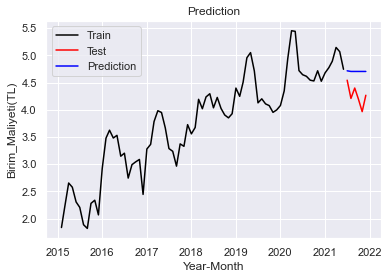

RMSE: 0.5335915655378022 for pdq = (0, 1, 3)
MSE: 0.2847199588130826 for pdq = (0, 1, 3)
R2: -7.847639588342954 for pdq = (0, 1, 3)
MAE: 0.4915458264363293 for pdq = (0, 1, 3)


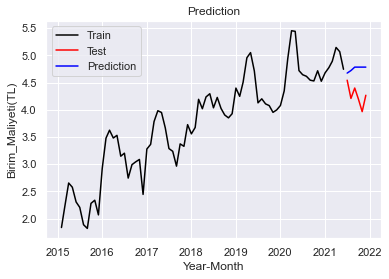

RMSE: 0.5134619028412906 for pdq = (0, 1, 4)
MSE: 0.2636431256693989 for pdq = (0, 1, 4)
R2: -7.192679451033515 for pdq = (0, 1, 4)
MAE: 0.4706547746928309 for pdq = (0, 1, 4)


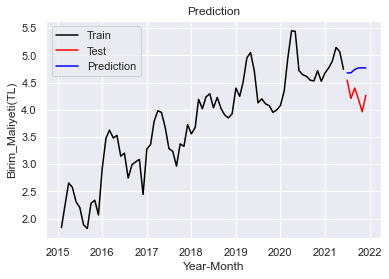

RMSE: 0.7981647796145164 for pdq = (0, 2, 0)
MSE: 0.6370670154170895 for pdq = (0, 2, 0)
R2: -18.79678337103194 for pdq = (0, 2, 0)
MAE: 0.6514960125391721 for pdq = (0, 2, 0)


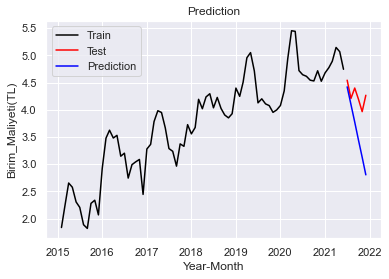

RMSE: 0.6550505906018611 for pdq = (0, 2, 1)
MSE: 0.4290912762478471 for pdq = (0, 2, 1)
R2: -12.333961477689748 for pdq = (0, 2, 1)
MAE: 0.6147142947092324 for pdq = (0, 2, 1)


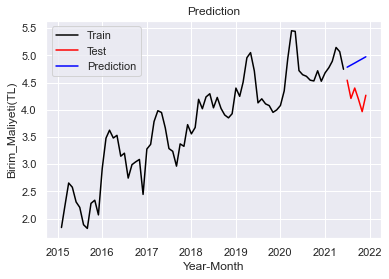

RMSE: 0.6331653130710323 for pdq = (0, 2, 2)
MSE: 0.4008983136763384 for pdq = (0, 2, 2)
R2: -11.457868446487433 for pdq = (0, 2, 2)
MAE: 0.5913533973459688 for pdq = (0, 2, 2)


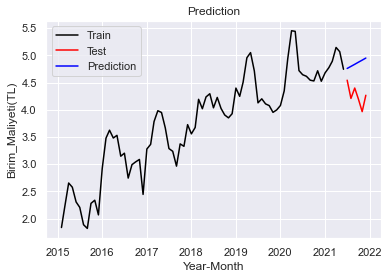

RMSE: 0.6123478547971567 for pdq = (0, 2, 3)
MSE: 0.37496989527467967 for pdq = (0, 2, 3)
R2: -10.652145861846856 for pdq = (0, 2, 3)
MAE: 0.570448237249205 for pdq = (0, 2, 3)


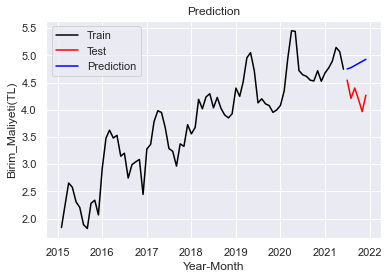

RMSE: 0.7124559101107278 for pdq = (0, 2, 4)
MSE: 0.5075934238517056 for pdq = (0, 2, 4)
R2: -14.773406579484721 for pdq = (0, 2, 4)
MAE: 0.6631632425566628 for pdq = (0, 2, 4)


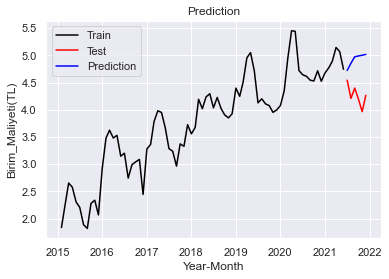

RMSE: 3.6452592716766965 for pdq = (0, 3, 0)
MSE: 13.28791515774492 for pdq = (0, 3, 0)
R2: -411.9204172630145 for pdq = (0, 3, 0)
MAE: 2.9421495758149177 for pdq = (0, 3, 0)


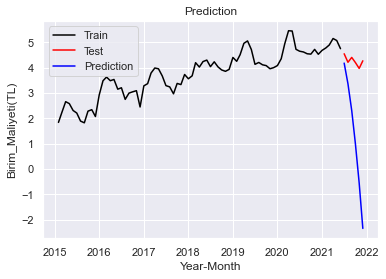

RMSE: 0.9083661637372745 for pdq = (0, 3, 1)
MSE: 0.825129087422773 for pdq = (0, 3, 1)
R2: -24.64079037454389 for pdq = (0, 3, 1)
MAE: 0.7409197631627614 for pdq = (0, 3, 1)


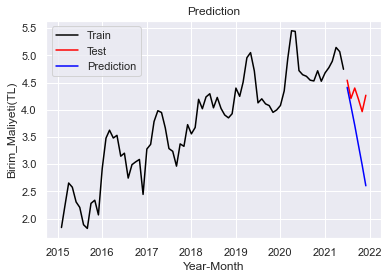

RMSE: 0.5590261080630123 for pdq = (0, 3, 2)
MSE: 0.3125101894960787 for pdq = (0, 3, 2)
R2: -8.711217772974113 for pdq = (0, 3, 2)
MAE: 0.5246952454032762 for pdq = (0, 3, 2)


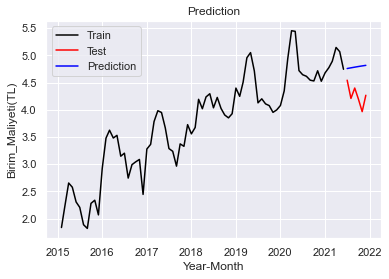

RMSE: 0.536167199105243 for pdq = (0, 3, 3)
MSE: 0.28747526539636126 for pdq = (0, 3, 3)
R2: -7.933260419793841 for pdq = (0, 3, 3)
MAE: 0.5000692047963384 for pdq = (0, 3, 3)


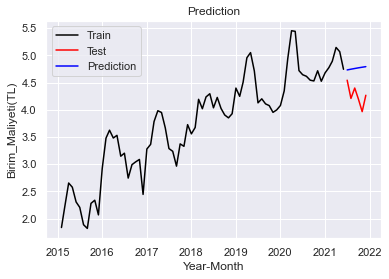

RMSE: 0.5046323023424604 for pdq = (0, 3, 4)
MSE: 0.2546537605674523 for pdq = (0, 3, 4)
R2: -6.913335976548589 for pdq = (0, 3, 4)
MAE: 0.4682914188667495 for pdq = (0, 3, 4)


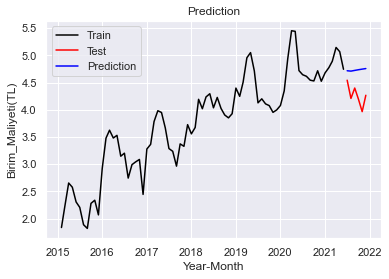

RMSE: 1.2349754307080083 for pdq = (0, 4, 0)
MSE: 1.5251643144524305 for pdq = (0, 4, 0)
R2: -46.39430359406622 for pdq = (0, 4, 0)
MAE: 1.1127023909786808 for pdq = (0, 4, 0)


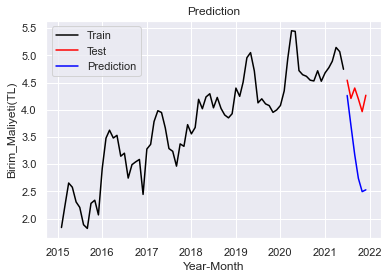

RMSE: 3.750330258176509 for pdq = (0, 4, 1)
MSE: 14.064977045394281 for pdq = (0, 4, 1)
R2: -436.067524997996 for pdq = (0, 4, 1)
MAE: 3.020274858068403 for pdq = (0, 4, 1)


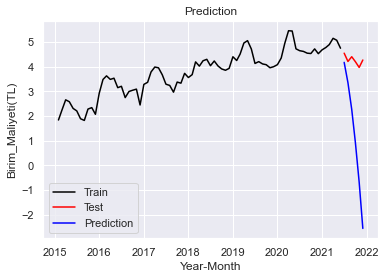

RMSE: 0.9720061865101742 for pdq = (0, 4, 2)
MSE: 0.9447960266140517 for pdq = (0, 4, 2)
R2: -28.359426584728457 for pdq = (0, 4, 2)
MAE: 0.7878578606572108 for pdq = (0, 4, 2)


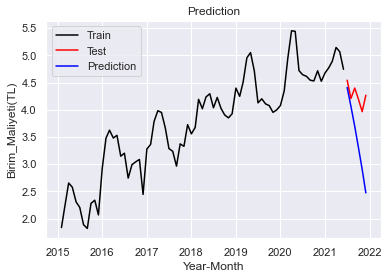

RMSE: 0.5061409782775429 for pdq = (0, 4, 3)
MSE: 0.25617868989174813 for pdq = (0, 4, 3)
R2: -6.960722977850884 for pdq = (0, 4, 3)
MAE: 0.47500149954108206 for pdq = (0, 4, 3)


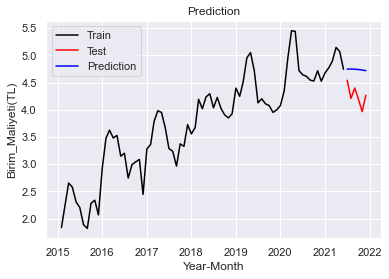

RMSE: 0.4570125060529499 for pdq = (0, 4, 4)
MSE: 0.20886043068879756 for pdq = (0, 4, 4)
R2: -5.490313579364198 for pdq = (0, 4, 4)
MAE: 0.42421033402004554 for pdq = (0, 4, 4)


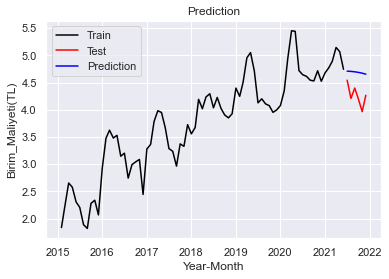

RMSE: 0.3516004278172545 for pdq = (1, 0, 0)
MSE: 0.12362286084127637 for pdq = (1, 0, 0)
R2: -2.8415660151227553 for pdq = (1, 0, 0)
MAE: 0.32085964923547294 for pdq = (1, 0, 0)


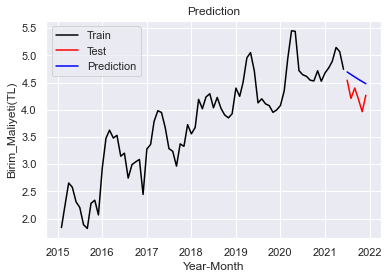

RMSE: 0.3038491052123751 for pdq = (1, 0, 1)
MSE: 0.09232427873836101 for pdq = (1, 0, 1)
R2: -1.8689662183710567 for pdq = (1, 0, 1)
MAE: 0.2693474003460435 for pdq = (1, 0, 1)


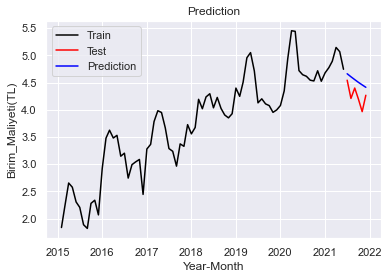

RMSE: 0.252220131887555 for pdq = (1, 0, 2)
MSE: 0.06361499492937563 for pdq = (1, 0, 2)
R2: -0.9768285647964843 for pdq = (1, 0, 2)
MAE: 0.21288596654898959 for pdq = (1, 0, 2)


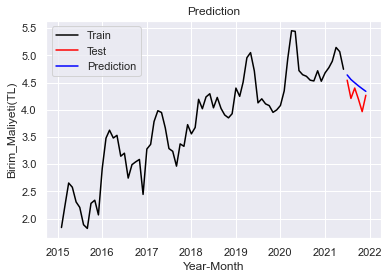

RMSE: 0.38262115580361006 for pdq = (1, 0, 3)
MSE: 0.14639894886849045 for pdq = (1, 0, 3)
R2: -3.5493303002021053 for pdq = (1, 0, 3)
MAE: 0.34652929761324297 for pdq = (1, 0, 3)


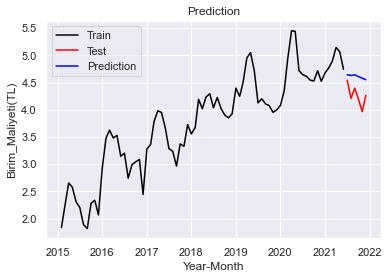

RMSE: 0.4320535275294058 for pdq = (1, 0, 4)
MSE: 0.18667025065060303 for pdq = (1, 0, 4)
R2: -4.800756316863756 for pdq = (1, 0, 4)
MAE: 0.3920473040543233 for pdq = (1, 0, 4)


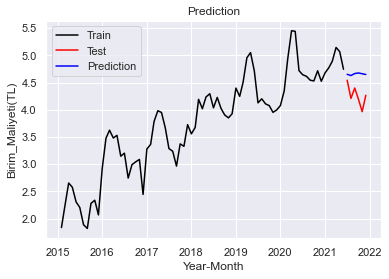

RMSE: 0.49073064253937293 for pdq = (1, 1, 0)
MSE: 0.2408165635271058 for pdq = (1, 1, 0)
R2: -6.483346688701563 for pdq = (1, 1, 0)
MAE: 0.4569358304677375 for pdq = (1, 1, 0)


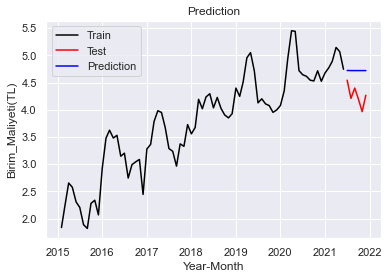

RMSE: 0.48985878551713863 for pdq = (1, 1, 1)
MSE: 0.23996162974832602 for pdq = (1, 1, 1)
R2: -6.456779721011359 for pdq = (1, 1, 1)
MAE: 0.4560846149375175 for pdq = (1, 1, 1)


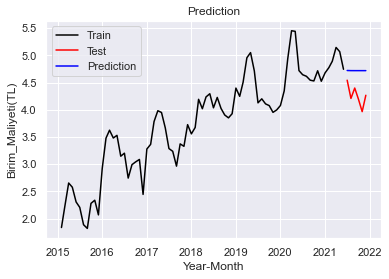

RMSE: 0.4722155114790352 for pdq = (1, 1, 2)
MSE: 0.2229874892814068 for pdq = (1, 1, 2)
R2: -5.929310281217706 for pdq = (1, 1, 2)
MAE: 0.4376245745108072 for pdq = (1, 1, 2)


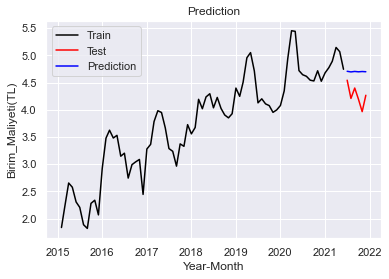

RMSE: 0.4805855830957554 for pdq = (1, 1, 3)
MSE: 0.23096250267948723 for pdq = (1, 1, 3)
R2: -6.177132894541222 for pdq = (1, 1, 3)
MAE: 0.4396660683307239 for pdq = (1, 1, 3)


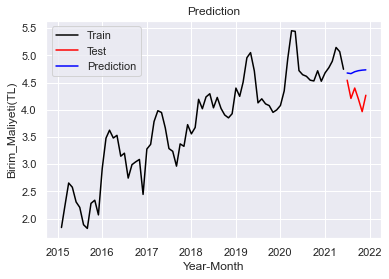

RMSE: 0.47621835924850175 for pdq = (1, 1, 4)
MSE: 0.2267839256853351 for pdq = (1, 1, 4)
R2: -6.0472841006929805 for pdq = (1, 1, 4)
MAE: 0.4352548162377528 for pdq = (1, 1, 4)


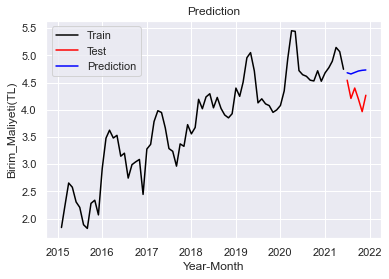

RMSE: 0.4857719175431601 for pdq = (1, 2, 0)
MSE: 0.23597435587355878 for pdq = (1, 2, 0)
R2: -6.332875649336791 for pdq = (1, 2, 0)
MAE: 0.3721660393797494 for pdq = (1, 2, 0)


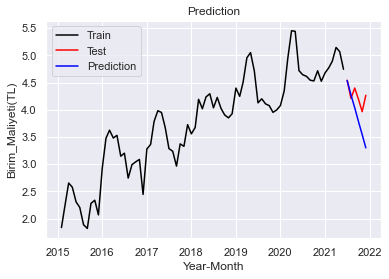

RMSE: 0.6298611859664304 for pdq = (1, 2, 1)
MSE: 0.39672511358703816 for pdq = (1, 2, 1)
R2: -11.328186739331775 for pdq = (1, 2, 1)
MAE: 0.58800953264817 for pdq = (1, 2, 1)


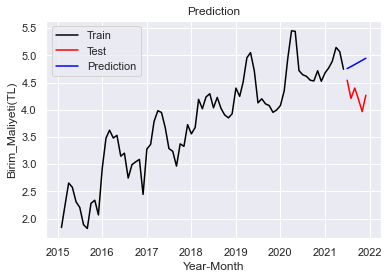

RMSE: 0.6574481588024514 for pdq = (1, 2, 2)
MSE: 0.43223808151273335 for pdq = (1, 2, 2)
R2: -12.431748085114384 for pdq = (1, 2, 2)
MAE: 0.6175066484678227 for pdq = (1, 2, 2)


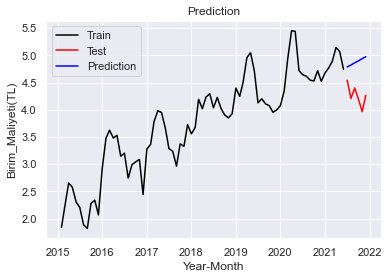

RMSE: 0.6093025546929006 for pdq = (1, 2, 3)
MSE: 0.37124960315529515 for pdq = (1, 2, 3)
R2: -10.536538217153158 for pdq = (1, 2, 3)
MAE: 0.5665717675831012 for pdq = (1, 2, 3)


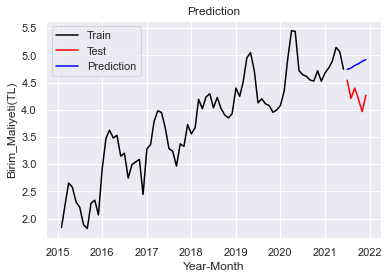

RMSE: 0.6641509686519755 for pdq = (1, 2, 4)
MSE: 0.44109650916135745 for pdq = (1, 2, 4)
R2: -12.707022693474004 for pdq = (1, 2, 4)
MAE: 0.6154731207651088 for pdq = (1, 2, 4)


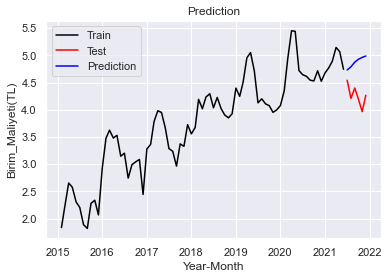

RMSE: 4.114456615064422 for pdq = (1, 3, 0)
MSE: 16.928753237247385 for pdq = (1, 3, 0)
R2: -525.0590369131393 for pdq = (1, 3, 0)
MAE: 3.3274327765723015 for pdq = (1, 3, 0)


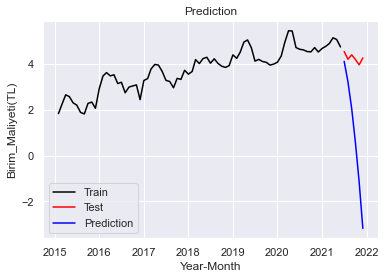

RMSE: 0.5981760917843596 for pdq = (1, 3, 1)
MSE: 0.35781463678241066 for pdq = (1, 3, 1)
R2: -10.11904820049147 for pdq = (1, 3, 1)
MAE: 0.45595513329150444 for pdq = (1, 3, 1)


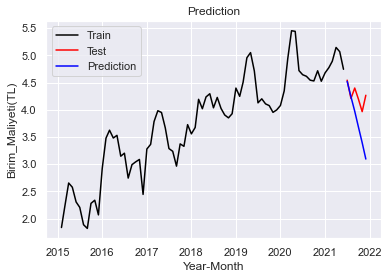

RMSE: 0.5293246649438335 for pdq = (1, 3, 2)
MSE: 0.2801846009179016 for pdq = (1, 3, 2)
R2: -7.706703869512472 for pdq = (1, 3, 2)
MAE: 0.4930898952039013 for pdq = (1, 3, 2)


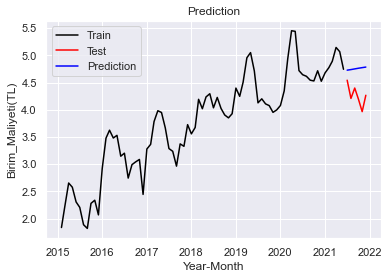

RMSE: 0.5639845921969466 for pdq = (1, 3, 3)
MSE: 0.31807862023555616 for pdq = (1, 3, 3)
R2: -8.884256110226367 for pdq = (1, 3, 3)
MAE: 0.5303718405554827 for pdq = (1, 3, 3)


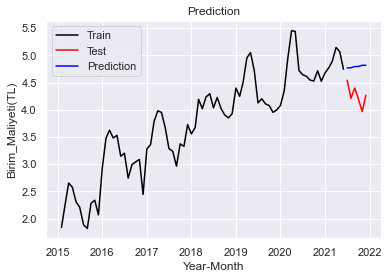

RMSE: 0.5396412317568712 for pdq = (1, 3, 4)
MSE: 0.2912126590120731 for pdq = (1, 3, 4)
R2: -8.049399491495873 for pdq = (1, 3, 4)
MAE: 0.5045655299796734 for pdq = (1, 3, 4)


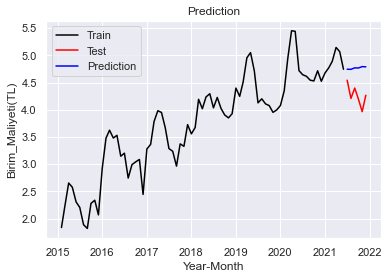

RMSE: 9.444333384222475 for pdq = (1, 4, 0)
MSE: 89.19543307233914 for pdq = (1, 4, 0)
R2: -2770.7377033912408 for pdq = (1, 4, 0)
MAE: 7.35300045974408 for pdq = (1, 4, 0)


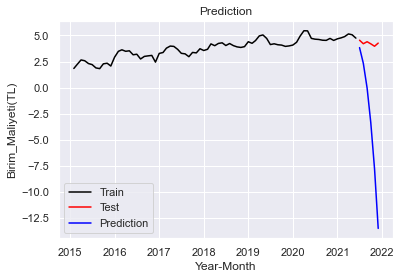

RMSE: 4.1605107427873635 for pdq = (1, 4, 1)
MSE: 17.309849640849063 for pdq = (1, 4, 1)
R2: -536.9015633083292 for pdq = (1, 4, 1)
MAE: 3.3620878009132196 for pdq = (1, 4, 1)


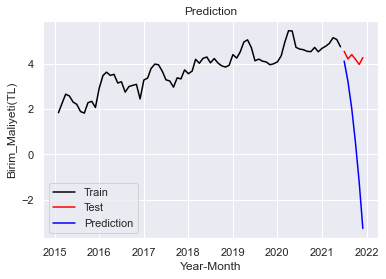

RMSE: 0.7465642765814382 for pdq = (1, 4, 2)
MSE: 0.5573582190675662 for pdq = (1, 4, 2)
R2: -16.31984179987854 for pdq = (1, 4, 2)
MAE: 0.5654374142936657 for pdq = (1, 4, 2)


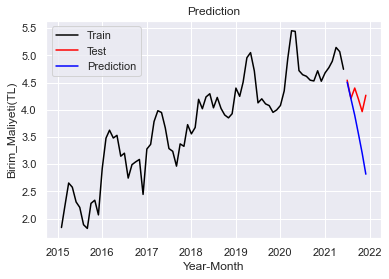

RMSE: 0.43979670752987 for pdq = (1, 4, 3)
MSE: 0.193421143954114 for pdq = (1, 4, 3)
R2: -5.010539540694704 for pdq = (1, 4, 3)
MAE: 0.4068081227808989 for pdq = (1, 4, 3)


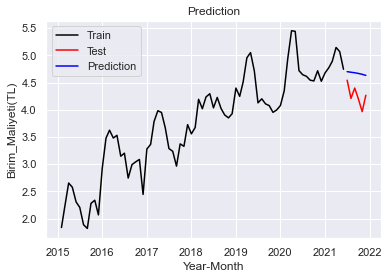

RMSE: 0.507775339193115 for pdq = (1, 4, 4)
MSE: 0.25783579509268306 for pdq = (1, 4, 4)
R2: -7.012217329138936 for pdq = (1, 4, 4)
MAE: 0.4765004974824265 for pdq = (1, 4, 4)


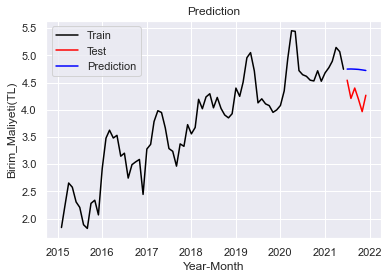

RMSE: 0.2912752112112173 for pdq = (2, 0, 0)
MSE: 0.08484124866613924 for pdq = (2, 0, 0)
R2: -1.6364319296483791 for pdq = (2, 0, 0)
MAE: 0.2557468970293127 for pdq = (2, 0, 0)


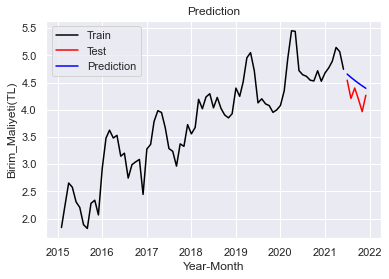

RMSE: 0.2814689375265519 for pdq = (2, 0, 1)
MSE: 0.07922476279232597 for pdq = (2, 0, 1)
R2: -1.4619002846886309 for pdq = (2, 0, 1)
MAE: 0.24518946116485477 for pdq = (2, 0, 1)


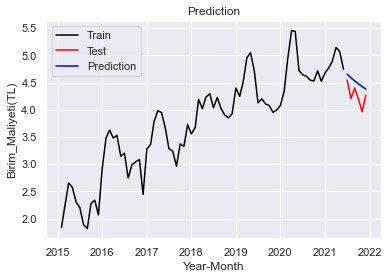

RMSE: 0.2668056973835454 for pdq = (2, 0, 2)
MSE: 0.07118528015632002 for pdq = (2, 0, 2)
R2: -1.2120742972986176 for pdq = (2, 0, 2)
MAE: 0.22860247620455723 for pdq = (2, 0, 2)


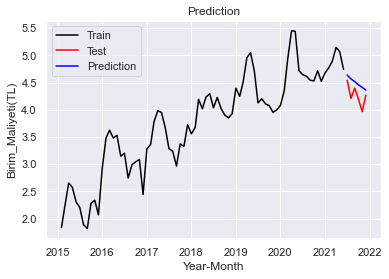

RMSE: 0.28992394981077546 for pdq = (2, 0, 3)
MSE: 0.08405589667388104 for pdq = (2, 0, 3)
R2: -1.6120272078773663 for pdq = (2, 0, 3)
MAE: 0.25325597835696617 for pdq = (2, 0, 3)


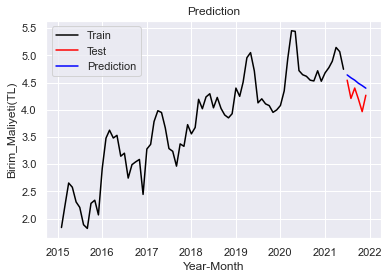

RMSE: 0.3087834059692797 for pdq = (2, 0, 4)
MSE: 0.09534719180198903 for pdq = (2, 0, 4)
R2: -1.962902890058456 for pdq = (2, 0, 4)
MAE: 0.273127558166718 for pdq = (2, 0, 4)


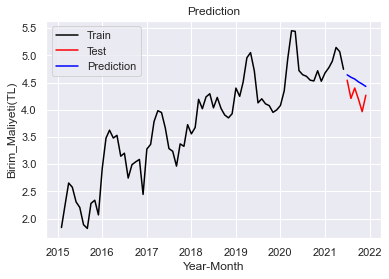

RMSE: 0.48680051210710995 for pdq = (2, 1, 0)
MSE: 0.2369747385877445 for pdq = (2, 1, 0)
R2: -6.363962425769399 for pdq = (2, 1, 0)
MAE: 0.45310728012128515 for pdq = (2, 1, 0)


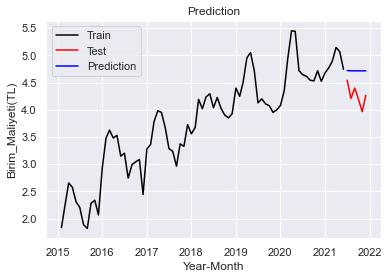

RMSE: 0.4746869879397815 for pdq = (2, 1, 1)
MSE: 0.22532773651934226 for pdq = (2, 1, 1)
R2: -6.002033191810923 for pdq = (2, 1, 1)
MAE: 0.44080311084846313 for pdq = (2, 1, 1)


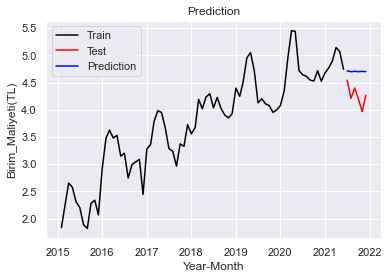

RMSE: 0.495949198118932 for pdq = (2, 1, 2)
MSE: 0.24596560711481166 for pdq = (2, 1, 2)
R2: -6.6433526190149985 for pdq = (2, 1, 2)
MAE: 0.4599745363648731 for pdq = (2, 1, 2)


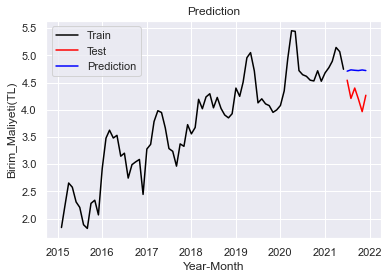

RMSE: 0.49025576813345195 for pdq = (2, 1, 3)
MSE: 0.240350718188121 for pdq = (2, 1, 3)
R2: -6.468870599001253 for pdq = (2, 1, 3)
MAE: 0.4500765594590412 for pdq = (2, 1, 3)


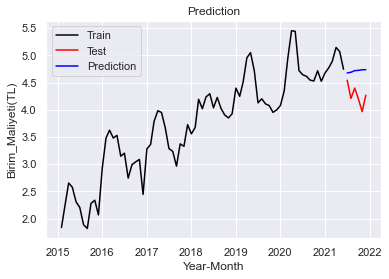

RMSE: 0.48433735347227597 for pdq = (2, 1, 4)
MSE: 0.23458267196852842 for pdq = (2, 1, 4)
R2: -6.28962923393291 for pdq = (2, 1, 4)
MAE: 0.44371990694221 for pdq = (2, 1, 4)


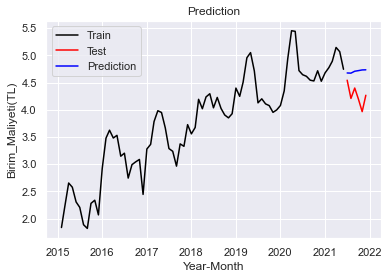

RMSE: 0.24761833770432518 for pdq = (2, 2, 0)
MSE: 0.06131484116745323 for pdq = (2, 2, 0)
R2: -0.9053515543048489 for pdq = (2, 2, 0)
MAE: 0.1883096640284041 for pdq = (2, 2, 0)


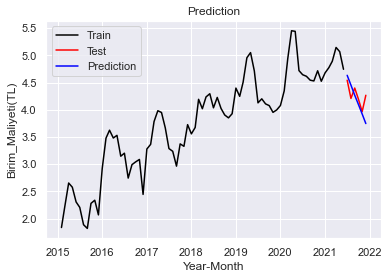

RMSE: 0.6244055835560511 for pdq = (2, 2, 1)
MSE: 0.3898823327759728 for pdq = (2, 2, 1)
R2: -11.115548121896174 for pdq = (2, 2, 1)
MAE: 0.582666964534711 for pdq = (2, 2, 1)


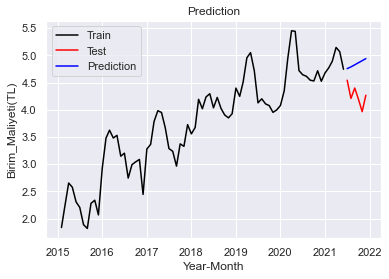

RMSE: 0.6112285069280708 for pdq = (2, 2, 2)
MSE: 0.3736002876815187 for pdq = (2, 2, 2)
R2: -10.609585465265381 for pdq = (2, 2, 2)
MAE: 0.5692638315610289 for pdq = (2, 2, 2)


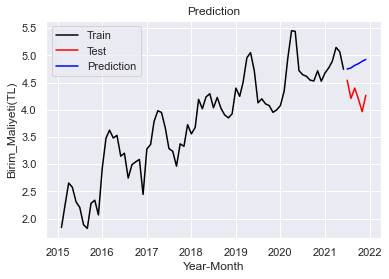

RMSE: 0.6353786603776232 for pdq = (2, 2, 3)
MSE: 0.40370604206326305 for pdq = (2, 2, 3)
R2: -11.545118279386495 for pdq = (2, 2, 3)
MAE: 0.5916388446616576 for pdq = (2, 2, 3)


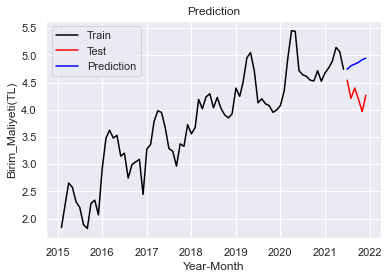

RMSE: 0.5816391442933091 for pdq = (2, 2, 4)
MSE: 0.3383040941742528 for pdq = (2, 2, 4)
R2: -9.512760359310251 for pdq = (2, 2, 4)
MAE: 0.5315476969220075 for pdq = (2, 2, 4)


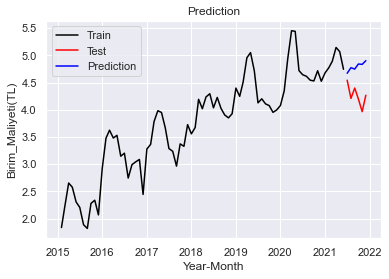

RMSE: 3.0881427972222024 for pdq = (2, 3, 0)
MSE: 9.53662593603537 for pdq = (2, 3, 0)
R2: -295.3495412215819 for pdq = (2, 3, 0)
MAE: 2.466269034201167 for pdq = (2, 3, 0)


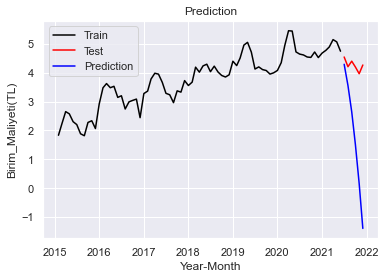

RMSE: 0.33612888135276975 for pdq = (2, 3, 1)
MSE: 0.11298262487946435 for pdq = (2, 3, 1)
R2: -2.5109219207730455 for pdq = (2, 3, 1)
MAE: 0.2642230446057416 for pdq = (2, 3, 1)


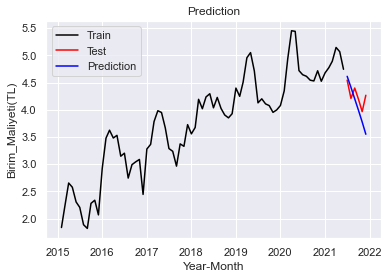

RMSE: 0.5165228227184487 for pdq = (2, 3, 2)
MSE: 0.26679582638903404 for pdq = (2, 3, 2)
R2: -7.2906492590284415 for pdq = (2, 3, 2)
MAE: 0.4806404419508696 for pdq = (2, 3, 2)


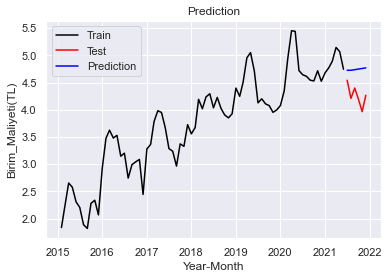

RMSE: 0.5308814348772498 for pdq = (2, 3, 3)
MSE: 0.2818350978973277 for pdq = (2, 3, 3)
R2: -7.7579928710861115 for pdq = (2, 3, 3)
MAE: 0.49462555803738467 for pdq = (2, 3, 3)


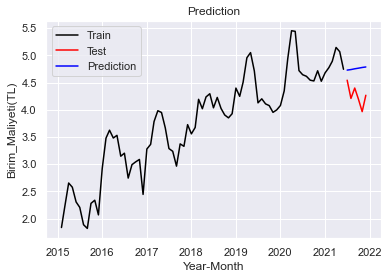

RMSE: 0.5300629371016771 for pdq = (2, 3, 4)
MSE: 0.2809667172888564 for pdq = (2, 3, 4)
R2: -7.731008044727998 for pdq = (2, 3, 4)
MAE: 0.4890365286805127 for pdq = (2, 3, 4)


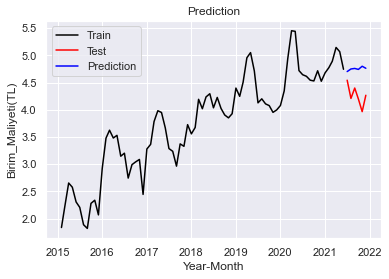

RMSE: 9.01827455566482 for pdq = (2, 4, 0)
MSE: 81.32927596135153 for pdq = (2, 4, 0)
R2: -2526.297786521944 for pdq = (2, 4, 0)
MAE: 7.001998852885978 for pdq = (2, 4, 0)


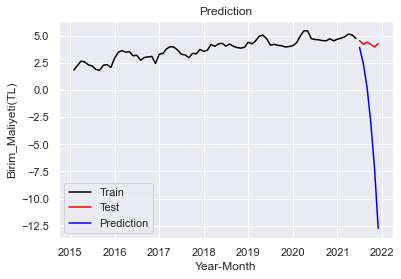

RMSE: 3.09793886722038 for pdq = (2, 4, 1)
MSE: 9.597225225034691 for pdq = (2, 4, 1)
R2: -297.23265707552815 for pdq = (2, 4, 1)
MAE: 2.4749032189256632 for pdq = (2, 4, 1)


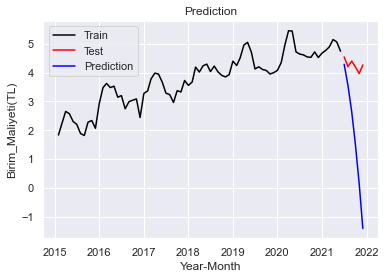

RMSE: 0.47539304120511755 for pdq = (2, 4, 2)
MSE: 0.2259985436262506 for pdq = (2, 4, 2)
R2: -6.02287844459884 for pdq = (2, 4, 2)
MAE: 0.3675199963344178 for pdq = (2, 4, 2)


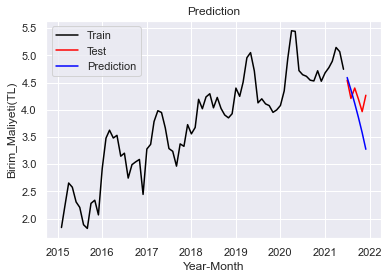

RMSE: 0.7542149128142058 for pdq = (2, 4, 3)
MSE: 0.5688401347113401 for pdq = (2, 4, 3)
R2: -16.676640992402167 for pdq = (2, 4, 3)
MAE: 0.5732642633272383 for pdq = (2, 4, 3)


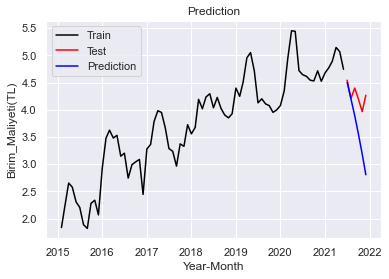

RMSE: 0.4385124041131708 for pdq = (2, 4, 4)
MSE: 0.1922931285611128 for pdq = (2, 4, 4)
R2: -4.975486593620032 for pdq = (2, 4, 4)
MAE: 0.40524706772256147 for pdq = (2, 4, 4)


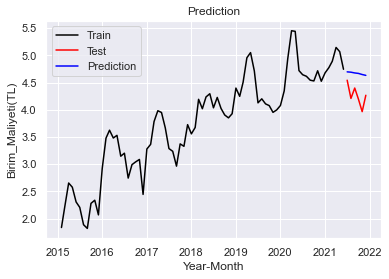

RMSE: 0.26439910382214865 for pdq = (3, 0, 0)
MSE: 0.06990688610195535 for pdq = (3, 0, 0)
R2: -1.1723483508210668 for pdq = (3, 0, 0)
MAE: 0.2265983672133768 for pdq = (3, 0, 0)


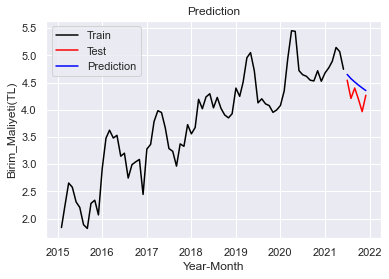

RMSE: 0.26031600338737637 for pdq = (3, 0, 1)
MSE: 0.06776442161957653 for pdq = (3, 0, 1)
R2: -1.1057715163415498 for pdq = (3, 0, 1)
MAE: 0.22192674918972996 for pdq = (3, 0, 1)


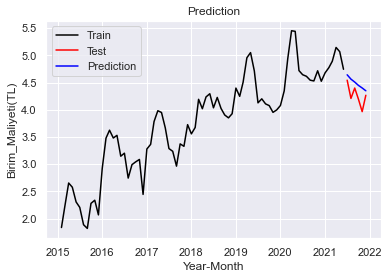

RMSE: 0.42672020715546144 for pdq = (3, 0, 2)
MSE: 0.1820901351947999 for pdq = (3, 0, 2)
R2: -4.658429762045208 for pdq = (3, 0, 2)
MAE: 0.3965853110714976 for pdq = (3, 0, 2)


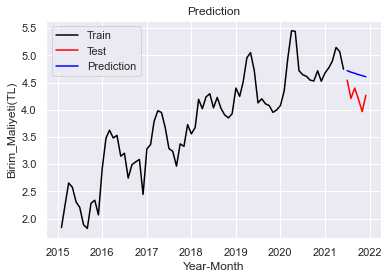

RMSE: 0.2912904305551217 for pdq = (3, 0, 3)
MSE: 0.08485011493298818 for pdq = (3, 0, 3)
R2: -1.6367074478589765 for pdq = (3, 0, 3)
MAE: 0.2527401724478513 for pdq = (3, 0, 3)


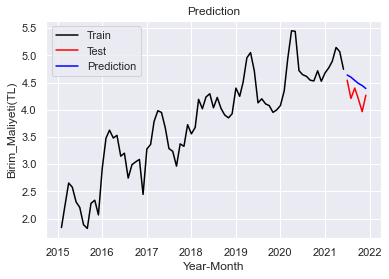

RMSE: 0.2570001788538683 for pdq = (3, 0, 4)
MSE: 0.06604909193092028 for pdq = (3, 0, 4)
R2: -1.0524678458729175 for pdq = (3, 0, 4)
MAE: 0.21299478244577585 for pdq = (3, 0, 4)


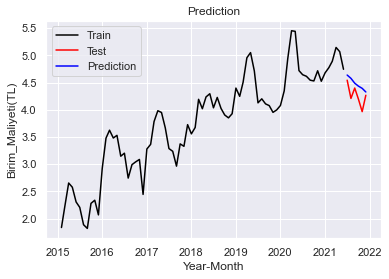

RMSE: 0.49450778434880127 for pdq = (3, 1, 0)
MSE: 0.24453794878156054 for pdq = (3, 1, 0)
R2: -6.598988302440364 for pdq = (3, 1, 0)
MAE: 0.4554508561428037 for pdq = (3, 1, 0)


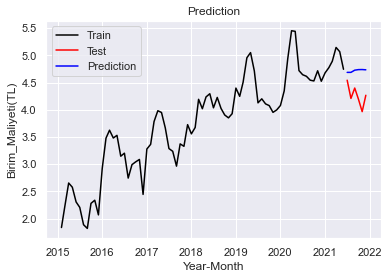

RMSE: 0.45392132039547656 for pdq = (3, 1, 1)
MSE: 0.2060445651095729 for pdq = (3, 1, 1)
R2: -5.402810884161307 for pdq = (3, 1, 1)
MAE: 0.40618467240751394 for pdq = (3, 1, 1)


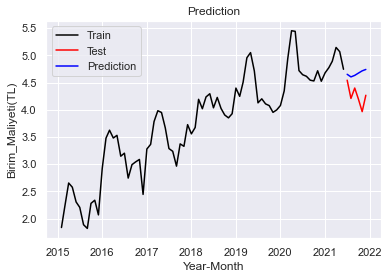

RMSE: 0.15638398137632412 for pdq = (3, 1, 2)
MSE: 0.02445594963111049 for pdq = (3, 1, 2)
R2: 0.24003421105864475 for pdq = (3, 1, 2)
MAE: 0.12248153639235444 for pdq = (3, 1, 2)


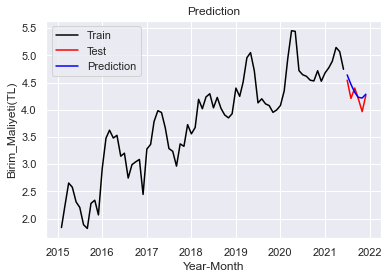

RMSE: 0.15114904987328173 for pdq = (3, 1, 3)
MSE: 0.022846035277595808 for pdq = (3, 1, 3)
R2: 0.2900621122545324 for pdq = (3, 1, 3)
MAE: 0.11709733627518037 for pdq = (3, 1, 3)


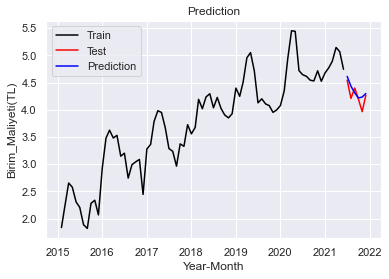

RMSE: 0.16641895391966408 for pdq = (3, 1, 4)
MSE: 0.027695268223715274 for pdq = (3, 1, 4)
R2: 0.1393727627405772 for pdq = (3, 1, 4)
MAE: 0.12693341754131357 for pdq = (3, 1, 4)


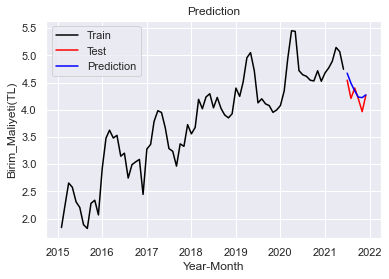

RMSE: 0.21236502441506994 for pdq = (3, 2, 0)
MSE: 0.04509890359481325 for pdq = (3, 2, 0)
R2: -0.40144318122175005 for pdq = (3, 2, 0)
MAE: 0.18656458957968658 for pdq = (3, 2, 0)


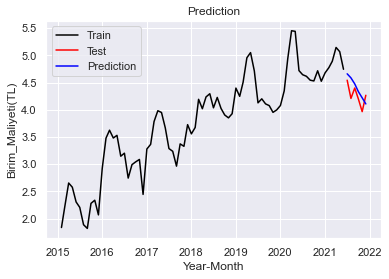

RMSE: 0.6457834085773773 for pdq = (3, 2, 1)
MSE: 0.41703621079381575 for pdq = (3, 2, 1)
R2: -11.959351721507625 for pdq = (3, 2, 1)
MAE: 0.5977336529715142 for pdq = (3, 2, 1)


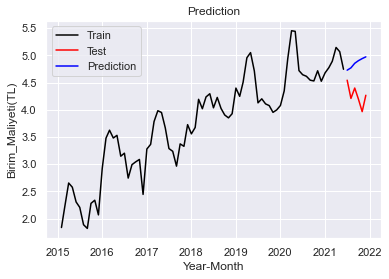

RMSE: 0.6392300494930242 for pdq = (3, 2, 2)
MSE: 0.4086150561748541 for pdq = (3, 2, 2)
R2: -11.697665321660974 for pdq = (3, 2, 2)
MAE: 0.5943157667670492 for pdq = (3, 2, 2)


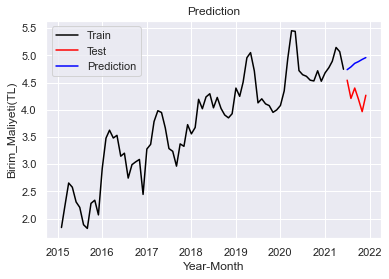

RMSE: 0.6316075551211366 for pdq = (3, 2, 3)
MSE: 0.39892810368609966 for pdq = (3, 2, 3)
R2: -11.396644400306572 for pdq = (3, 2, 3)
MAE: 0.5878486421531481 for pdq = (3, 2, 3)


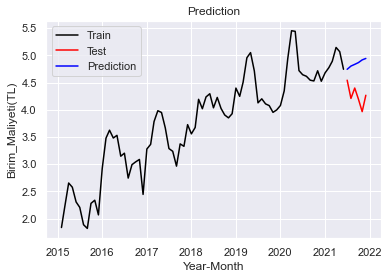

RMSE: 0.6915347864362467 for pdq = (3, 2, 4)
MSE: 0.4782203608514252 for pdq = (3, 2, 4)
R2: -13.860642064782102 for pdq = (3, 2, 4)
MAE: 0.6527318699484509 for pdq = (3, 2, 4)


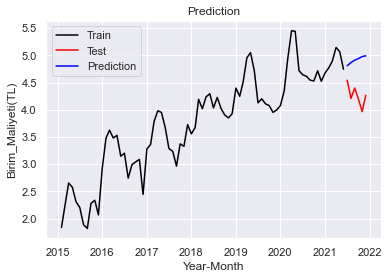

RMSE: 2.098438735295103 for pdq = (3, 3, 0)
MSE: 4.40344512578691 for pdq = (3, 3, 0)
R2: -135.83654487174613 for pdq = (3, 3, 0)
MAE: 1.6339512658257682 for pdq = (3, 3, 0)


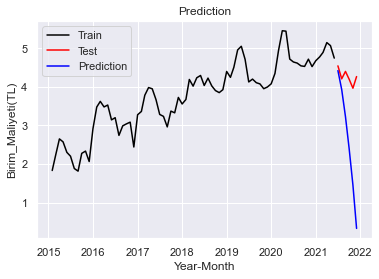

RMSE: 0.2040071519832715 for pdq = (3, 3, 1)
MSE: 0.04161891806032564 for pdq = (3, 3, 1)
R2: -0.2933030356901658 for pdq = (3, 3, 1)
MAE: 0.15706876648348533 for pdq = (3, 3, 1)


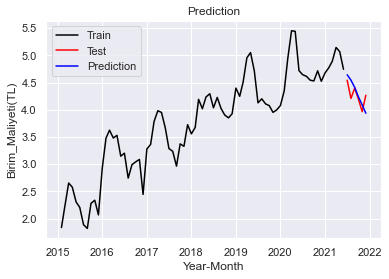

RMSE: 0.5224413664587807 for pdq = (3, 3, 2)
MSE: 0.272944981387318 for pdq = (3, 3, 2)
R2: -7.481733535046445 for pdq = (3, 3, 2)
MAE: 0.4824815193590881 for pdq = (3, 3, 2)


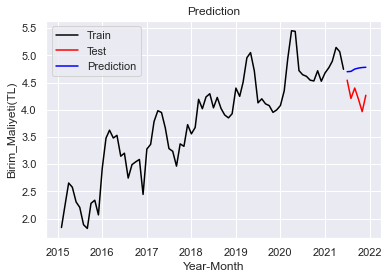

RMSE: 0.5219520863620701 for pdq = (3, 3, 3)
MSE: 0.2724339804577179 for pdq = (3, 3, 3)
R2: -7.465854240622349 for pdq = (3, 3, 3)
MAE: 0.4866814344008474 for pdq = (3, 3, 3)


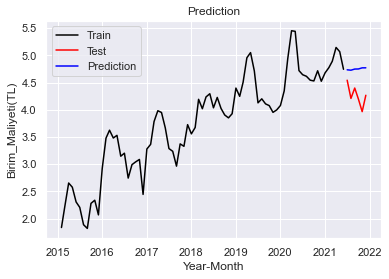

RMSE: 0.5914222741647859 for pdq = (3, 3, 4)
MSE: 0.3497803063782472 for pdq = (3, 3, 4)
R2: -9.869382318106418 for pdq = (3, 3, 4)
MAE: 0.5422476778902888 for pdq = (3, 3, 4)


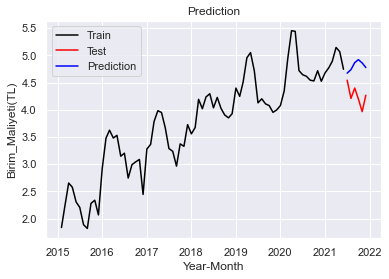

RMSE: 6.729959722045669 for pdq = (3, 4, 0)
MSE: 45.29235786035701 for pdq = (3, 4, 0)
R2: -1406.4547500119886 for pdq = (3, 4, 0)
MAE: 5.21290149907044 for pdq = (3, 4, 0)


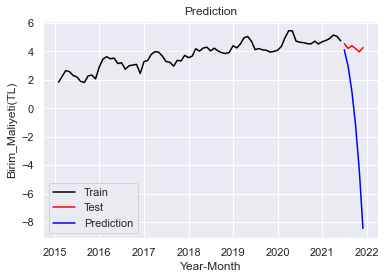

RMSE: 2.0933593887863275 for pdq = (3, 4, 1)
MSE: 4.382153530619867 for pdq = (3, 4, 1)
R2: -135.17491102955182 for pdq = (3, 4, 1)
MAE: 1.6318742714156718 for pdq = (3, 4, 1)


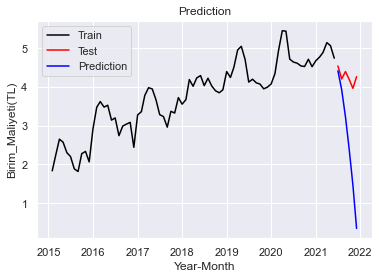

RMSE: 0.26248113988934096 for pdq = (3, 4, 2)
MSE: 0.06889634879760777 for pdq = (3, 4, 2)
R2: -1.14094602168083 for pdq = (3, 4, 2)
MAE: 0.1846976124419147 for pdq = (3, 4, 2)


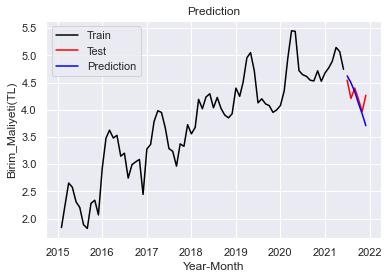

RMSE: 0.45105888624375934 for pdq = (3, 4, 3)
MSE: 0.2034541188594606 for pdq = (3, 4, 3)
R2: -5.322313068379399 for pdq = (3, 4, 3)
MAE: 0.34955221411115156 for pdq = (3, 4, 3)


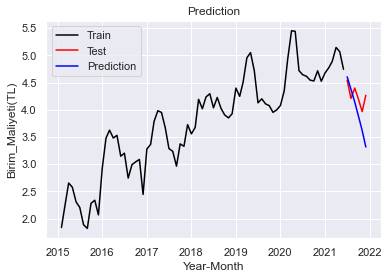

RMSE: 0.7850569635886882 for pdq = (3, 4, 4)
MSE: 0.6163144360790908 for pdq = (3, 4, 4)
R2: -18.151899383001982 for pdq = (3, 4, 4)
MAE: 0.6028210470511585 for pdq = (3, 4, 4)


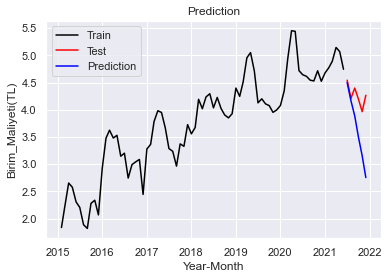

RMSE: 0.29992249261430476 for pdq = (4, 0, 0)
MSE: 0.0899535015759777 for pdq = (4, 0, 0)
R2: -1.7952945939282743 for pdq = (4, 0, 0)
MAE: 0.2628813743407477 for pdq = (4, 0, 0)


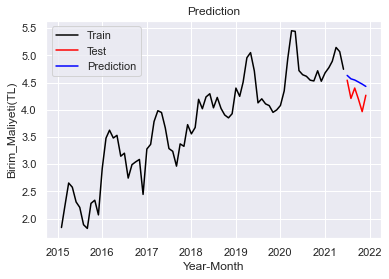

RMSE: 0.28829911357612126 for pdq = (4, 0, 1)
MSE: 0.08311637888877728 for pdq = (4, 0, 1)
R2: -1.5828318020333607 for pdq = (4, 0, 1)
MAE: 0.2516768854125808 for pdq = (4, 0, 1)


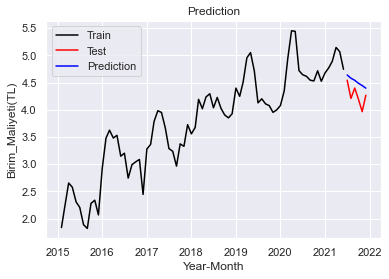

RMSE: 0.2846432427111342 for pdq = (4, 0, 2)
MSE: 0.08102177562110967 for pdq = (4, 0, 2)
R2: -1.517742249231568 for pdq = (4, 0, 2)
MAE: 0.24574846330060499 for pdq = (4, 0, 2)


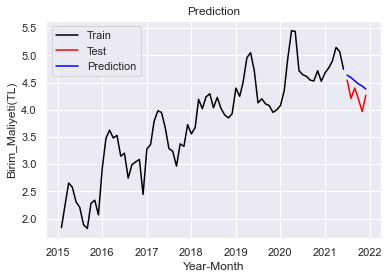

RMSE: 0.2882368417204418 for pdq = (4, 0, 3)
MSE: 0.08308047692497501 for pdq = (4, 0, 3)
R2: -1.58171615268598 for pdq = (4, 0, 3)
MAE: 0.24943641828121446 for pdq = (4, 0, 3)


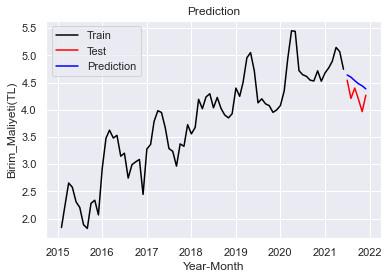

RMSE: 0.2758863305108986 for pdq = (4, 0, 4)
MSE: 0.0761132673627688 for pdq = (4, 0, 4)
R2: -1.3652109262879741 for pdq = (4, 0, 4)
MAE: 0.24004185347894605 for pdq = (4, 0, 4)


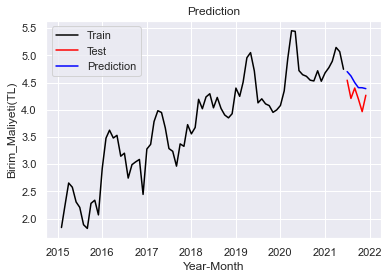

RMSE: 0.4926967713396891 for pdq = (4, 1, 0)
MSE: 0.24275010848855386 for pdq = (4, 1, 0)
R2: -6.543431373379324 for pdq = (4, 1, 0)
MAE: 0.45042949939366334 for pdq = (4, 1, 0)


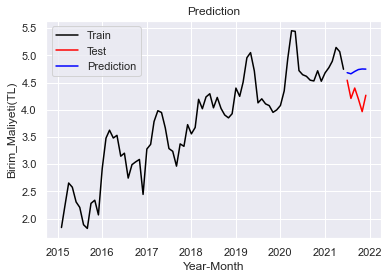

RMSE: 0.4414523318328198 for pdq = (4, 1, 1)
MSE: 0.194880161280634 for pdq = (4, 1, 1)
R2: -5.055878334336042 for pdq = (4, 1, 1)
MAE: 0.3943829485602208 for pdq = (4, 1, 1)


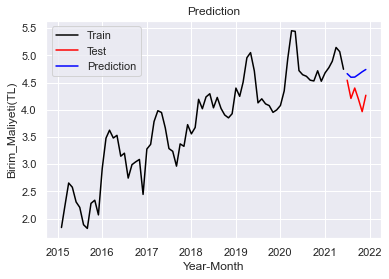

RMSE: 0.45611677570637815 for pdq = (4, 1, 2)
MSE: 0.20804251308078248 for pdq = (4, 1, 2)
R2: -5.464896884873076 for pdq = (4, 1, 2)
MAE: 0.4087190720105263 for pdq = (4, 1, 2)


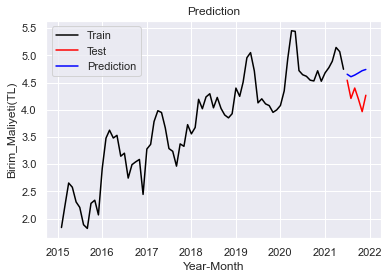

RMSE: 0.15891670317389725 for pdq = (4, 1, 3)
MSE: 0.025254518547660563 for pdq = (4, 1, 3)
R2: 0.21521877490326458 for pdq = (4, 1, 3)
MAE: 0.1257006738606686 for pdq = (4, 1, 3)


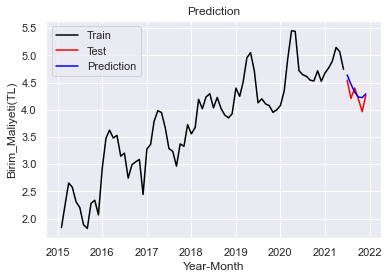

RMSE: 0.15376792930887262 for pdq = (4, 1, 4)
MSE: 0.02364457608393845 for pdq = (4, 1, 4)
R2: 0.26524754962057695 for pdq = (4, 1, 4)
MAE: 0.12016795200260733 for pdq = (4, 1, 4)


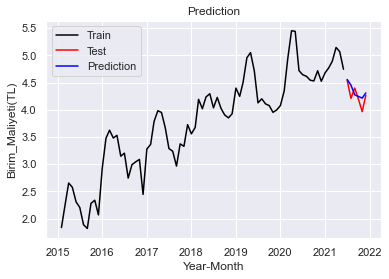

RMSE: 0.23511610063405147 for pdq = (4, 2, 0)
MSE: 0.05527958077736142 for pdq = (4, 2, 0)
R2: -0.7178065399829348 for pdq = (4, 2, 0)
MAE: 0.20547756948642038 for pdq = (4, 2, 0)


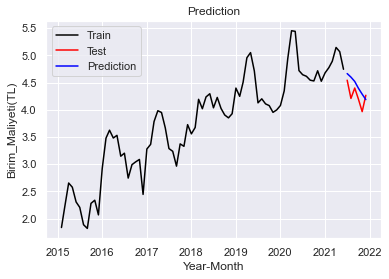

RMSE: 0.6550931373125359 for pdq = (4, 2, 1)
MSE: 0.42914701855398113 for pdq = (4, 2, 1)
R2: -12.335693663366342 for pdq = (4, 2, 1)
MAE: 0.6027783879211399 for pdq = (4, 2, 1)


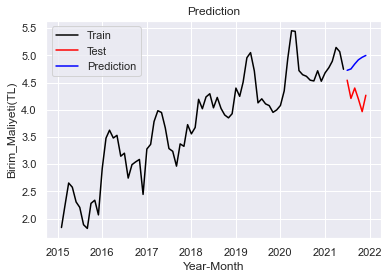

RMSE: 0.6452721385519324 for pdq = (4, 2, 2)
MSE: 0.41637613279138425 for pdq = (4, 2, 2)
R2: -11.93883987439282 for pdq = (4, 2, 2)
MAE: 0.5970206648779902 for pdq = (4, 2, 2)


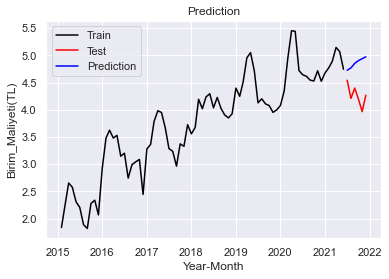

RMSE: 0.6316469286034269 for pdq = (4, 2, 3)
MSE: 0.3989778424141426 for pdq = (4, 2, 3)
R2: -11.398190025492601 for pdq = (4, 2, 3)
MAE: 0.5878106625403202 for pdq = (4, 2, 3)


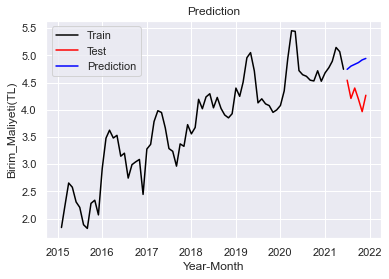

RMSE: 0.6287042737252082 for pdq = (4, 2, 4)
MSE: 0.3952690638003415 for pdq = (4, 2, 4)
R2: -11.282940161645126 for pdq = (4, 2, 4)
MAE: 0.5852628627734169 for pdq = (4, 2, 4)


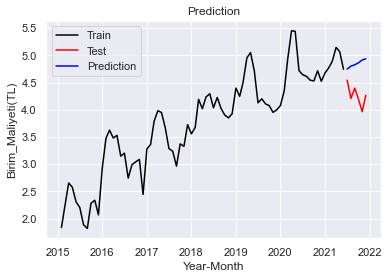

RMSE: 1.7319318181380257 for pdq = (4, 3, 0)
MSE: 2.9995878226788872 for pdq = (4, 3, 0)
R2: -92.21184253917403 for pdq = (4, 3, 0)
MAE: 1.3292948118973207 for pdq = (4, 3, 0)


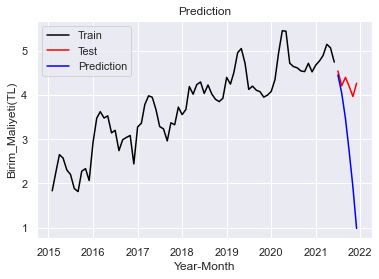

RMSE: 0.20184459446806016 for pdq = (4, 3, 1)
MSE: 0.04074124031597567 for pdq = (4, 3, 1)
R2: -0.26602930191649565 for pdq = (4, 3, 1)
MAE: 0.1733339203183828 for pdq = (4, 3, 1)


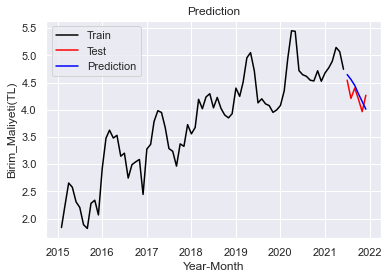

RMSE: 0.20291742907385518 for pdq = (4, 3, 2)
MSE: 0.04117548302194304 for pdq = (4, 3, 2)
R2: -0.27952334347326757 for pdq = (4, 3, 2)
MAE: 0.15288299350649912 for pdq = (4, 3, 2)


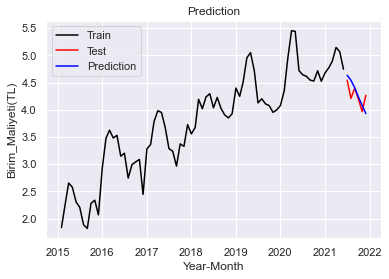

RMSE: 0.4759858355634557 for pdq = (4, 3, 3)
MSE: 0.22656251565704108 for pdq = (4, 3, 3)
R2: -6.040403809828383 for pdq = (4, 3, 3)
MAE: 0.4380350052248591 for pdq = (4, 3, 3)


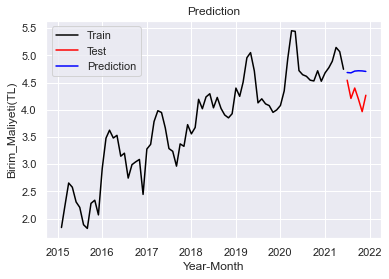

RMSE: 0.5047553649416835 for pdq = (4, 3, 4)
MSE: 0.25477797843741207 for pdq = (4, 3, 4)
R2: -6.917196032402829 for pdq = (4, 3, 4)
MAE: 0.46443563374745905 for pdq = (4, 3, 4)


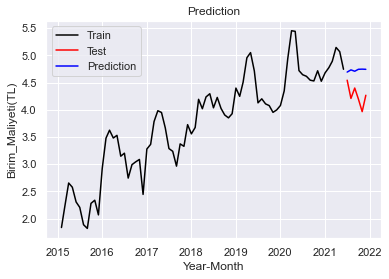

RMSE: 6.718298842093274 for pdq = (4, 4, 0)
MSE: 45.13553933167182 for pdq = (4, 4, 0)
R2: -1401.5816324814693 for pdq = (4, 4, 0)
MAE: 5.221810826054045 for pdq = (4, 4, 0)


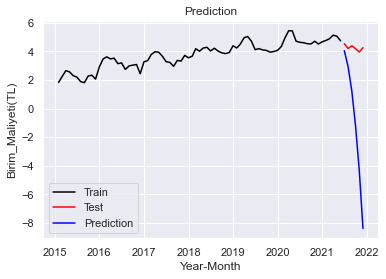

RMSE: 1.7250913534739611 for pdq = (4, 4, 1)
MSE: 2.975940177830623 for pdq = (4, 4, 1)
R2: -91.4769947273003 for pdq = (4, 4, 1)
MAE: 1.3263036409209215 for pdq = (4, 4, 1)


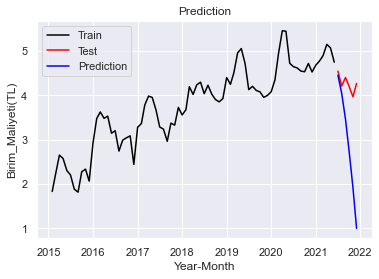

RMSE: 2.143333137941739 for pdq = (4, 4, 2)
MSE: 4.593876940199182 for pdq = (4, 4, 2)
R2: -141.75419134478497 for pdq = (4, 4, 2)
MAE: 1.6793375648134286 for pdq = (4, 4, 2)


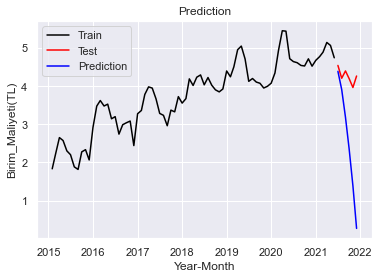

RMSE: 0.19528441938808738 for pdq = (4, 4, 3)
MSE: 0.0381360044557424 for pdq = (4, 4, 3)
R2: -0.18507190072108837 for pdq = (4, 4, 3)
MAE: 0.15530833976429204 for pdq = (4, 4, 3)


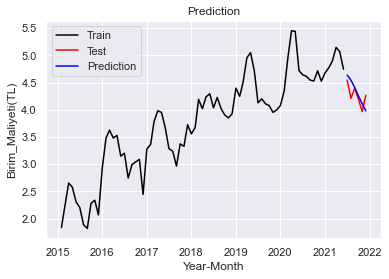

RMSE: 0.5109328321937562 for pdq = (4, 4, 4)
MSE: 0.261052359013533 for pdq = (4, 4, 4)
R2: -7.112171678680099 for pdq = (4, 4, 4)
MAE: 0.39816321219885764 for pdq = (4, 4, 4)


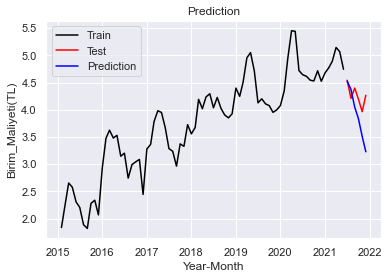

In [26]:
apply_arima(df_logscale2015)

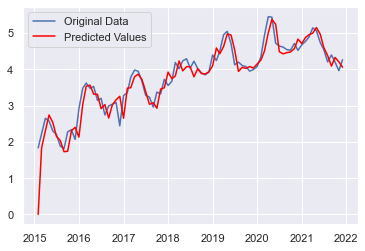

In [27]:
train = df_logscale2015[df_logscale2015.index < pd.to_datetime("2021-07-01", format='%Y-%m-%d')]
test = df_logscale2015[df_logscale2015.index > pd.to_datetime("2021-06-01", format='%Y-%m-%d')]
model = ARIMA(df_logscale2015,order=(3,1,3))
result_ARIMA = model.fit()
forecasts = result_ARIMA.predict(n_periods=len(test))
plt.plot(df_logscale2015,label="Original Data")
plt.plot(result_ARIMA.fittedvalues,color='red',label="Predicted Values")
plt.legend()
plt.show()

RMSE: 0.15114904987328173 for pdq = (3, 1, 3)
MSE: 0.022846035277595808 for pdq = (3, 1, 3)
R2: 0.2900621122545324 for pdq = (3, 1, 3)
MAE: 0.11709733627518037 for pdq = (3, 1, 3)


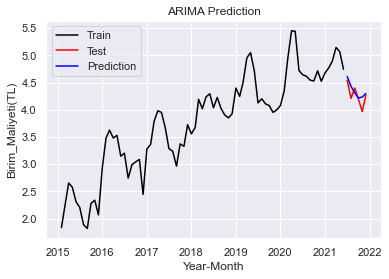

In [41]:
#Forecast with optimum p,d,q values
y = train["Birim_Maliyeti(TL)"]
ARIMAmodel = ARIMA(y, order = (3, 1, 3))
ARIMAmodel = ARIMAmodel.fit()

y_pred_arima = ARIMAmodel.get_forecast(len(test.index))
y_pred_arima = y_pred_arima.conf_int(alpha = 0.05) 
y_pred_arima["Predictions"] = ARIMAmodel.predict(start = y_pred_arima.index[0], end = y_pred_arima.index[-1])
y_pred_arima.index = test.index
forecast = y_pred_arima["Predictions"]
rms = np.sqrt(metrics.mean_squared_error(test,forecast))
mse = metrics.mean_squared_error(test,forecast)
r2 = metrics.r2_score(test,forecast)
mae = metrics.mean_absolute_error(test,forecast)
print(f"RMSE: {rms} for pdq = {(3, 1, 3)}", )
print(f"MSE: {mse} for pdq = {(3, 1, 3)}")
print(f"R2: {r2} for pdq = {(3, 1, 3)}")
print(f"MAE: {mae} for pdq = {(3, 1, 3)}")
plt.plot(train, color = "black",label="Train")
plt.plot(test, color = "red",label="Test")
plt.plot(forecast,color='blue',label="Prediction")
plt.title("ARIMA Prediction")
plt.ylabel("Birim_Maliyeti(TL)")
plt.xlabel('Year-Month')
sns.set()
plt.legend()
plt.show()

In [36]:
predicted_data = np.exp(forecast)

In [37]:
predicted_data

Donem
2021-07-01    100.757413
2021-08-01     84.173849
2021-09-01     74.424579
2021-10-01     67.790411
2021-11-01     68.984412
2021-12-01     73.514186
Name: Predictions, dtype: float64

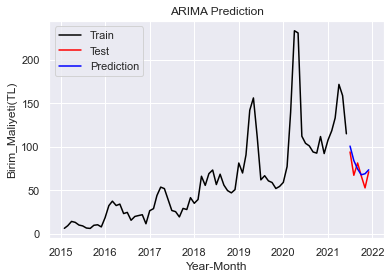

In [40]:
#Logaritmic to Exp result
after2015result = df_group[df_group.index > pd.to_datetime("2015-01-01", format='%Y-%m-%d')]
train_result = after2015result[after2015result.index < pd.to_datetime("2021-07-01", format='%Y-%m-%d')]
testresult = after2015result[after2015result.index > pd.to_datetime("2021-06-01", format='%Y-%m-%d')]
plt.plot(train_result, color = "black",label="Train")
plt.plot(testresult, color = "red",label="Test")
plt.plot(predicted_data,color='blue',label="Prediction")
plt.title("ARIMA Prediction")
plt.ylabel("Birim_Maliyeti(TL)")
plt.xlabel('Year-Month')
sns.set()
plt.legend()
plt.show()

# RANDOM FOREST REGRESSOR 

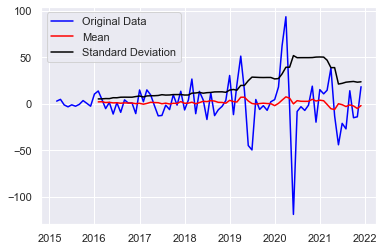

         Values                       Metric
0 -7.290573e+00              Test Statistics
1  1.420805e-10                      p-value
2  9.000000e+00             No. of lags used
3  7.200000e+01  Number of observations used
4 -3.524624e+00          critical value (1%)
5 -2.902607e+00          critical value (5%)
6 -2.588679e+00         critical value (10%)


In [29]:
after2015 = df_group[df_group.index > pd.to_datetime("2015-01-01", format='%Y-%m-%d')]
after2015diff = after2015.copy()
after2015diff["Birim_Maliyeti(TL)"] = after2015["Birim_Maliyeti(TL)"].diff() #Time difference 
after2015diff = after2015diff[1:] #to get rid of NaN
test_stationary(after2015diff)

In [30]:
df_bm = after2015diff[['Birim_Maliyeti(TL)']]
df_bm.loc[:,'LastMonth'] = df_bm.loc[:,'Birim_Maliyeti(TL)'].shift()
df_bm.loc[:,'LastMonth_Diff'] = df_bm.loc[:,'LastMonth'].diff()
# dropping NAs
df_bm = df_bm.dropna()

In [31]:
def regression_results(y_true, y_pred):
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    #mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))    
    #print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
def rmse(actual, predict):
    predict = np.array(predict)
    actual = np.array(actual)
    distance = predict - actual
    square_distance = distance ** 2
    mean_square_distance = square_distance.mean()
    score = np.sqrt(mean_square_distance)
    return score
rmse_score = make_scorer(rmse, greater_is_better = False)
train2 = df_bm[df_bm.index < pd.to_datetime("2021-07-01", format='%Y-%m-%d')]
test2 = df_bm[df_bm.index > pd.to_datetime("2021-06-01", format='%Y-%m-%d')]
X_train = train2.drop("Birim_Maliyeti(TL)",axis=1).copy()
y_train = train2["Birim_Maliyeti(TL)"].copy()
X_test = test2.drop("Birim_Maliyeti(TL)",axis=1).copy()
y_test = test2["Birim_Maliyeti(TL)"].copy()
model_rf = RandomForestRegressor()
param_search_rf = { 
    'n_estimators': [10,20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]
}
tscv_rf = TimeSeriesSplit(n_splits=10)
gsearch_rf = GridSearchCV(estimator=model_rf, cv=tscv_rf, param_grid=param_search_rf, scoring = rmse_score)
gsearch_rf.fit(X_train, y_train)
best_model_rf = gsearch_rf.best_estimator_
y_true_rf = y_test.values
y_pred_rf = best_model_rf.predict(X_test)
regression_results(y_true_rf, y_pred_rf)

explained_variance:  -0.3703
r2:  -0.8211
MAE:  22.2347
MSE:  543.5358
RMSE:  23.3139


In [32]:
# creating copy of original dataframe
df_bm2 = df_bm.copy()
# inserting column with lastmonth-1 values
df_bm2['LastMonth-1'] = df_bm2['LastMonth'].shift()
# inserting column with difference in lastmonth-1 and lastmonth-2 values.
df_bm2['LastMonth-1_Diff'] = df_bm2['LastMonth-1'].diff()
# dropping NAs
df_bm2 = df_bm2.dropna()

In [33]:
def regression_results(y_true, y_pred):
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))    
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
def rmse(actual, predict):
    predict = np.array(predict)
    actual = np.array(actual)
    distance = predict - actual
    square_distance = distance ** 2
    mean_square_distance = square_distance.mean()
    score = np.sqrt(mean_square_distance)
    return score
rmse_score = make_scorer(rmse, greater_is_better = False)
train2 = df_bm2[df_bm2.index < pd.to_datetime("2021-07-01", format='%Y-%m-%d')]
test2 = df_bm2[df_bm2.index > pd.to_datetime("2021-06-01", format='%Y-%m-%d')]
X_train = train2.drop("Birim_Maliyeti(TL)",axis=1).copy()
y_train = train2["Birim_Maliyeti(TL)"].copy()
X_test = test2.drop("Birim_Maliyeti(TL)",axis=1).copy()
y_test = test2["Birim_Maliyeti(TL)"].copy()
model_rf = RandomForestRegressor()
param_search_rf = { 
    'n_estimators': [10,20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]
}
tscv_rf = TimeSeriesSplit(n_splits=10)
gsearch_rf = GridSearchCV(estimator=model_rf, cv=tscv_rf, param_grid=param_search_rf, scoring = rmse_score)
gsearch_rf.fit(X_train, y_train)
best_model_rf = gsearch_rf.best_estimator_
y_true_rf = y_test.values
y_pred_rf = best_model_rf.predict(X_test)
regression_results(y_true_rf, y_pred_rf)

explained_variance:  -0.0679
r2:  -0.3206
MAE:  18.6972
MSE:  394.163
RMSE:  19.8535


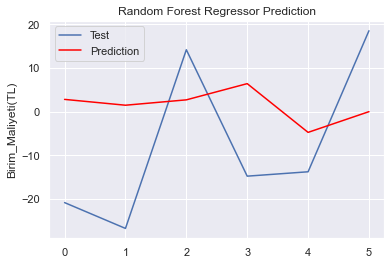

In [42]:
plt.plot(y_true_rf,label="Test")
plt.plot(y_pred_rf,color='red',label="Prediction")
plt.ylabel("Birim_Maliyeti(TL)")
plt.title("Random Forest Regressor Prediction")
plt.legend()
plt.show()